<i>Copyright (c) Recommenders contributors.</i>

<i>Licensed under the MIT License.</i>

# Neural Collaborative Filtering (NCF)

This notebook serves as an introduction to Neural Collaborative Filtering (NCF), which is an innovative algorithm based on deep neural networks to tackle the key problem in recommendation — collaborative filtering — on the basis of implicit feedback.

In [ ]:
pip install recommenders numpy pandas tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.0/356.0 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.7/261.7 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install "pandera>=0.5.0,<0.17"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.6/152.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.10.3
    Uninstalling pydantic-2.10.3:
      Successfully uninstalled pydantic-2.10.3
  Attempting uninstall: pandera
    Found existing installation: pandera 0.21.1
    Uninstalling pandera-0.21.1:
      Successfully uninstalled pandera-0.21.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.20 requires pydantic>=2.7.0, but you have pydantic 1.10.19 which is incompatible.
google-genai 0.3.0 requires pydantic<3.0.0dev,>=2.0.0, but you have pydantic 1.10.19 which is incompatible.
langchain 0.3.12 requires pydantic<3.0.0,>=2.7.4, but y

## 0 Global Settings and Imports

In [ ]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('INFO') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (
    map, ndcg_at_k, precision_at_k, recall_at_k
)
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.utils.notebook_utils import store_metadata

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Pandas version: 2.2.2
Tensorflow version: 2.17.1


In [ ]:
# top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

# Model parameters
EPOCHS = 100
BATCH_SIZE = 256

SEED = DEFAULT_SEED  # Set None for non-deterministic results

In [ ]:
df = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=["userID", "itemID", "rating", "timestamp"]
)

df.head()

100%|██████████| 4.81k/4.81k [00:00<00:00, 9.97kKB/s]


,userID,itemID,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [ ]:
train, test = python_chrono_split(df, 0.75)

Filter out any users or items in the test set that do not appear in the training set.

In [ ]:
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [ ]:
leave_one_out_test = test.groupby("userID").last().reset_index()

Create a test set containing the last interaction for each user as for the leave-one-out evaluation.

Write datasets to csv files.

In [ ]:
train_file = "./train.csv"
test_file = "./test.csv"
leave_one_out_test_file = "./leave_one_out_test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)
leave_one_out_test.to_csv(leave_one_out_test_file, index=False)

In [ ]:
data = NCFDataset(train_file=train_file, test_file=leave_one_out_test_file, seed=SEED, overwrite_test_file_full=True)

  0%|          | 0/943 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dis

In [ ]:
def evaluate_model_with_hr_ndcg(model, data, top_k=10):
    """
    Đánh giá mô hình bằng HR và NDCG.

    Args:
        model: Mô hình NCF đã huấn luyện.
        data: Dữ liệu kiểm tra (test loader).
        top_k: Số lượng sản phẩm trong Top-K.

    Returns:
        eval_hr: Giá trị trung bình HR@K.
        eval_ndcg: Giá trị trung bình NDCG@K.
    """
    ndcgs = []
    hit_ratio = []

    for b in data.test_loader():  # Duyệt qua từng batch trong tập test
        user_input, item_input, labels = b
        output = model.predict(user_input, item_input, is_list=True)  # Dự đoán điểm

        output = np.squeeze(output)  # Loại bỏ các chiều không cần thiết
        rank = sum(output >= output[0])  # Vị trí của item thực tế trong danh sách dự đoán

        if rank <= top_k:  # Nếu item thực tế nằm trong Top-K
            ndcgs.append(1 / np.log2(rank + 1))  # Cộng điểm NDCG
            hit_ratio.append(1)  # Cộng điểm HR
        else:
            ndcgs.append(0)  # Không cộng điểm NDCG
            hit_ratio.append(0)  # Không cộng điểm HR

    eval_ndcg = np.mean(ndcgs)  # Tính NDCG trung bình
    eval_hr = np.mean(hit_ratio)  # Tính HR trung bình

    print("HR@{}: {:.6f}".format(top_k, eval_hr))
    print("NDCG@{}: {:.6f}".format(top_k, eval_ndcg))

    return eval_hr, eval_ndcg


In [ ]:
def evaluate_model_on_train(model, data, batch_size=256, top_k=10):
    """
    Đánh giá mô hình trên tập train bằng HR và NDCG.

    Args:
        model: Mô hình NCF đã huấn luyện.
        data: Dữ liệu train (train loader).
        batch_size: Kích thước batch.
        top_k: Số lượng sản phẩm trong Top-K.

    Returns:
        eval_hr: Giá trị trung bình HR@K.
        eval_ndcg: Giá trị trung bình NDCG@K.
    """
    ndcgs = []
    hit_ratio = []

    # Lấy dữ liệu train loader
    train_loader = data.train_loader(batch_size=batch_size)

    for b in train_loader:  # Duyệt qua từng batch trong tập train
        user_input, item_input, labels = b
        output = model.predict(user_input, item_input, is_list=True)  # Dự đoán điểm

        output = np.squeeze(output)  # Loại bỏ các chiều không cần thiết
        rank = sum(output >= output[0])  # Vị trí của item thực tế trong danh sách dự đoán

        if rank <= top_k:  # Nếu item thực tế nằm trong Top-K
            ndcgs.append(1 / np.log2(rank + 1))  # Cộng điểm NDCG
            hit_ratio.append(1)  # Cộng điểm HR
        else:
            ndcgs.append(0)  # Không cộng điểm NDCG
            hit_ratio.append(0)  # Không cộng điểm HR

    eval_ndcg = np.mean(ndcgs)  # Tính NDCG trung bình
    eval_hr = np.mean(hit_ratio)  # Tính HR trung bình

    print("HR@{} (train): {:.6f}".format(top_k, eval_hr))
    print("NDCG@{} (train): {:.6f}".format(top_k, eval_ndcg))

    return eval_hr, eval_ndcg


In [ ]:
import matplotlib.pyplot as plt

# Tham số cần tinh chỉnh
n_factors_list = [4, 8, 16, 32]
hr_test_values = []
ndcg_test_values = []
hr_train_values = []
ndcg_train_values = []

# Cố định các tham số khác
layer_sizes = [16, 8, 4]
n_epochs = 100
batch_size = 256
learning_rate = 0.001

for n_factors in n_factors_list:
    print(f"Training model with n_factors={n_factors}")

    # Tạo mô hình
    model = NCF(
        n_users=data.n_users,
        n_items=data.n_items,
        model_type="NeuMF",
        n_factors=n_factors,
        layer_sizes=layer_sizes,
        n_epochs=n_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        verbose=10,
        seed=SEED
    )

    # Huấn luyện mô hình
    model.fit(data)

    # Đánh giá trên tập test
    hr_test, ndcg_test = evaluate_model_with_hr_ndcg(model, data, top_k=10)
    hr_test_values.append(hr_test)
    ndcg_test_values.append(ndcg_test)

    # Đánh giá trên tập train
    hr_train, ndcg_train = evaluate_model_on_train(model, data, batch_size=batch_size, top_k=10)
    hr_train_values.append(hr_train)
    ndcg_train_values.append(ndcg_train)

Training model with n_factors=4
HR@10: 0.534464
NDCG@10: 0.284561
HR@10 (train): 0.040111
NDCG@10 (train): 0.017447
Training model with n_factors=8
HR@10: 0.545069
NDCG@10: 0.292043
HR@10 (train): 0.038728
NDCG@10 (train): 0.018317
Training model with n_factors=16
HR@10: 0.523860
NDCG@10: 0.280162
HR@10 (train): 0.034578
NDCG@10 (train): 0.014541
Training model with n_factors=32
HR@10: 0.499470
NDCG@10: 0.272599
HR@10 (train): 0.038036
NDCG@10 (train): 0.017499


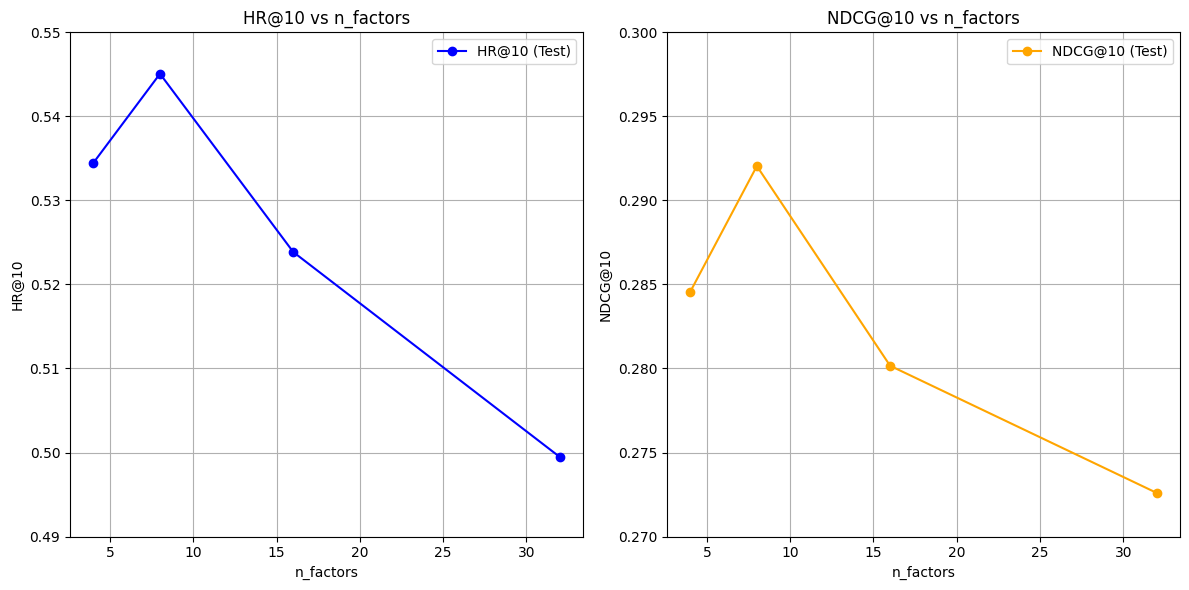

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 6))

# HR@10 trên tập test
plt.subplot(1, 2, 1)
plt.plot(n_factors_list, hr_test_values, marker='o', label='HR@10 (Test)', color='blue')
plt.ylim(0.49, 0.55)  # Điều chỉnh trục Y để giảm khoảng cách
plt.title('HR@10 vs n_factors')
plt.xlabel('n_factors')
plt.ylabel('HR@10')
plt.grid(True)
plt.legend()

# NDCG@10 trên tập test
plt.subplot(1, 2, 2)
plt.plot(n_factors_list, ndcg_test_values, marker='o', label='NDCG@10 (Test)', color='orange')
plt.ylim(0.27, 0.30)  # Điều chỉnh trục Y để giảm khoảng cách
plt.title('NDCG@10 vs n_factors')
plt.xlabel('n_factors')
plt.ylabel('NDCG@10')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig('n_factors.png')
from google.colab import files
files.download('n_factors.png')

Training model with layer_sizes=[16, 8, 4]


/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


HR@10: 0.521739
NDCG@10: 0.285506
Training model with layer_sizes=[32, 16, 8]
HR@10: 0.511135
NDCG@10: 0.274689
Training model with layer_sizes=[64, 32, 16]
HR@10: 0.468717
NDCG@10: 0.247002
Training model with layer_sizes=[128, 64, 32]
HR@10: 0.490986
NDCG@10: 0.264653


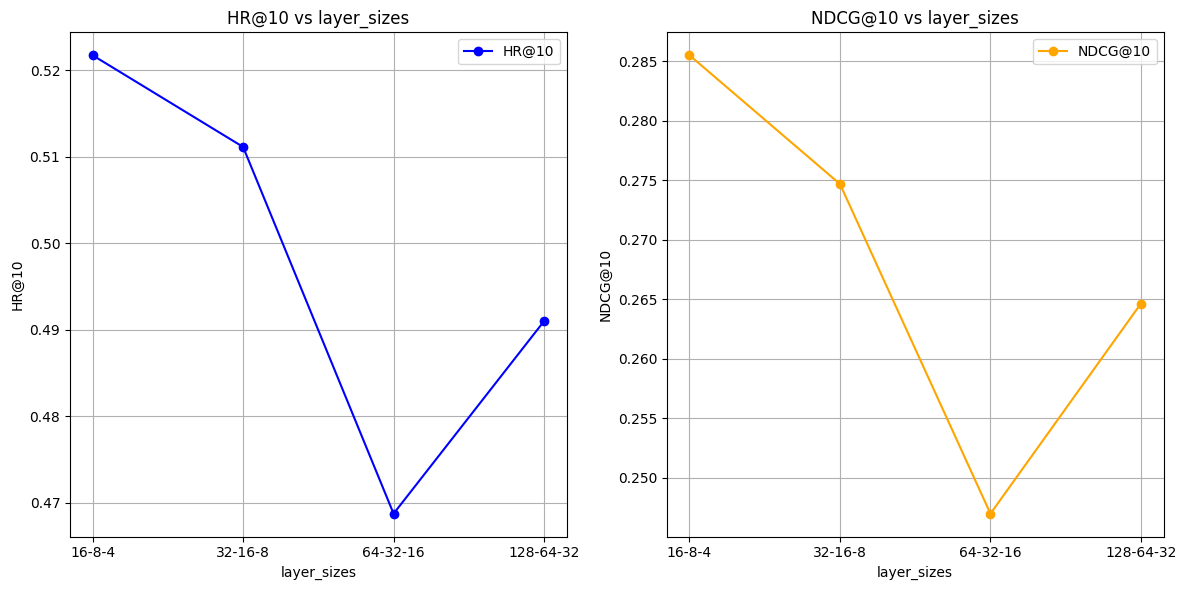

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Các giá trị layer_sizes cần thử nghiệm
layer_sizes_list = [
    [16, 8, 4],  # Lớp nhỏ
    [32, 16, 8], # Lớp trung bình
    [64, 32, 16], # Lớp lớn
    [128, 64, 32] # Lớp rất lớn
]

# Cố định các tham số khác
n_factors = 4
batch_size = 256
learning_rate = 0.001
n_epochs = 100
top_k = 10

# Khởi tạo danh sách lưu kết quả
hr_values = []
ndcg_values = []

# Tinh chỉnh layer_sizes
for layer_sizes in layer_sizes_list:
    print(f"Training model with layer_sizes={layer_sizes}")

    # Tạo mô hình NCF
    model = NCF(
        n_users=data.n_users,
        n_items=data.n_items,
        model_type="NeuMF",
        n_factors=n_factors,
        layer_sizes=layer_sizes,
        n_epochs=n_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        verbose=10,
        seed=SEED
    )

    # Huấn luyện mô hình
    model.fit(data)
    # Đánh giá HR và NDCG
    hr, ndcg = evaluate_model_with_hr_ndcg(model, data, top_k=top_k)

    # Lưu kết quả
    hr_values.append(hr)
    ndcg_values.append(ndcg)

# Vẽ biểu đồ
layer_labels = ['16-8-4', '32-16-8', '64-32-16', '128-64-32']

plt.figure(figsize=(12, 6))

# HR@K
plt.subplot(1, 2, 1)
plt.plot(layer_labels, hr_values, marker='o', label='HR@10', color='blue')
plt.title('HR@10 vs layer_sizes')
plt.xlabel('layer_sizes')
plt.ylabel('HR@10')
plt.grid(True)
plt.legend()

# NDCG@K
plt.subplot(1, 2, 2)
plt.plot(layer_labels, ndcg_values, marker='o', label='NDCG@10', color='orange')
plt.title('NDCG@10 vs layer_sizes')
plt.xlabel('layer_sizes')
plt.ylabel('NDCG@10')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#save the plot to image in google drive
plt.savefig('layer_labels.png')
from google.colab import files
files.download('layer_labels.png')
